In [1]:
from IPython.display import display, Math, Latex

import pandas as pd
import numpy as np
import numpy_financial as npf
import yfinance as yf
import matplotlib.pyplot as plt
from datetime import datetime, timedelta, timezone
from threading import Thread
import random

## CFM 101 Final Group Assignment - Automated Financial Portfolio Generator

***
### Runtime Note

* We hope you are having a nice day $\ddot\smile$, our code's runtime mainly depends on the magnitude of `TRIALS` below.
* We have tested this entire notebook on a MBP 2017 with an i5 and 8gb of RAM with a list of 150 tickers, which took approx. 4 mins to run.
* Lowering this variable (to 100) will improve runtime to about 2 minutes, but may cost some accuracy. 


### VPN
* Sometimes, yFinance produces Data that is delayed by a few hours, so it may not contain data from `2021-11-26`. If it does this, this just means that we are being throttled by Yahoo Finance on the University's Internet Network. Using a mobile hotspot or VPN usually produces the desired result. See @193 on Piazza.
***

In [2]:
TRIALS = 1000

# Setup - Threaded

* `Threading` used with permission from Professor Thompson

In [3]:
# For daily info, we want to program this dynamically. However, getting the end day is rather tricky since 
# the stock market is only active on business days, and only has closing data after 5pm EST on a trading day.
# This code determines a value DELTA that represents how many business days to subtract from today to get a trading day.
now = datetime.now(timezone(timedelta(hours=-5), 'EST'))

# US Markets close at 4pm, but afterhours trading ends at 8pm.
# yFinance stubbornly only gives the day's data after 8pm, so we will wait until 9pm to pull data from
# the current day.
market_close = now.replace(hour=21, minute=0, second=0, microsecond=0)
if now < market_close:
    DELTA = 1
# If it is saturday or sunday
elif now.weekday() >= 5:
    DELTA = 1
else:
    DELTA = 0

In [4]:
DELTA

0

# Input Filtering
The code below first reads in `Tickers.csv`, and follows by performing some cleanup of the tickers file to ensure they will both work properly with our code and follow the specifications of the assignment. 

* First, our code will remove any duplicate tickers using the `drop_duplicates()` function method. It then produces a `Tickers` object that stores **all** unique tickers from our `Tickers.csv` file.

* Next, our code will initialize an empty dictionary, `ticker_info_dict`, which acts as a cache for all of our API calls.

* We then call on the yFinance API to give us the info of every Ticker using the `get_info()` function. This simultaneously checks if:
```
* The ticker is in the correct market, it will add its `.info` into the `ticker_info_dict`. Otherwise, it will print out an error that can be seen below (if there are any).
```


***

In [5]:
# Setup - Threaded

ticker_input = pd.read_csv('Tickers.csv', header=None, keep_default_na=False) # reads in csv file and stores it
ticker_input.columns = ["Tickers"]
ticker_input.drop_duplicates(inplace=True)
ticker_input["Tickers"] = [ticker for ticker in dict.fromkeys(ticker_input["Tickers"])]
tickers = yf.Tickers(" ".join([ticker for ticker in ticker_input["Tickers"]]))
ticker_info_dict = {}

# Checks to see if every ticker in the list is a legitimate ticker and that it trades in the 
# US market AND denominated in USD. If it does not, it will drop it from the list.
def get_info(ticker):
    try: 
        ticker_info = tickers.tickers[ticker].info
        if "market" in ticker_info.keys():
            # Check if the stock is listed in the US market, and denominated in USD
            if ticker_info["market"] == 'us_market' and ticker_info["currency"] == 'USD':
                ticker_info_dict[ticker] = ticker_info
            else:
                print(f"Found {ticker} is not denominated in USD or in the US Market - Skipped")
    except KeyError as error:
        print(f'Error: Stock not found | Error - {ticker}: {error}')

# Threaded Calls
threads = []

for ticker in ticker_input["Tickers"]:
    thread = Thread(target=get_info, args=(ticker,))
    threads.append(thread)
    thread.start()

for thread in threads:
    thread.join()

Error: Stock not found | Error - sdf: 'sdf'Error: Stock not found | Error - w3432: 'w3432'

Error: Stock not found | Error - d: 'd'Error: Stock not found | Error - b: 'b'

Error: Stock not found | Error - cv: 'cv'
Error: Stock not found | Error - ;v.'v.x c: ";v.'v.x c"Error: Stock not found | Error - cx: 'cx'

Error: Stock not found | Error - vx: 'vx'
Error: Stock not found | Error - b ;;earwa: 'b ;;earwa'
Error: Stock not found | Error -  w4r: ' w4r'
Error: Stock not found | Error -  er: ' er'
Error: Stock not found | Error -  gd: ' gd'
Error: Stock not found | Error -  g: ' g'
Error: Stock not found | Error -   d: '  d'
Error: Stock not found | Error -   f: '  f'
Error: Stock not found | Error -    ds: '   ds'
Error: Stock not found | Error -    f : '   f '
Error: Stock not found | Error - bea: 'bea'
Error: Stock not found | Error - bean: 'bean'Error: Stock not found | Error - empty: 'empty'

Error: Stock not found | Error - haha: 'haha'Error: Stock not found | Error - oki thinks fdh

***

## Download Stock History Data


In [6]:
# yf.download() gives us the historical data for a space-separated string-list of tickers 
# This also removes all stocks that have no stock history information. 

ticker_hist = yf.download(
                tickers = " ".join([ticker for ticker in ticker_info_dict.keys()]),
                # Download Data From the past 6 months
                period = "6mo",
                interval = "1d",
                group_by = 'ticker',
                threads = True
            )

[*********************100%***********************]  87 of 87 completed


***

### Daily volume
* We then check if the daily volume of each ticker fulfills the requirements (`>10 000` shares per day)
* If the stock does not have any historical data, we also drop it from our list.
* As always, we keep a log of what is happening below the code box.


In [7]:
# Initialize start dates
daily_vol_start = '2021-07-02'
daily_vol_end = '2021-10-22'


# Defines a function get_daily_volume that produces the average daily volume of a stock over a specified time frame.
# Inputs: 
# ticker is of type String, represents the ticker of a desired stock
# start is of type String, represents the starting date of interval, default is previously defined
# end is of type String, represents the ending date of interval, defauly is previously defined
# Outputs:
# output is of type Float

def get_daily_volume(ticker, start=daily_vol_start, end=daily_vol_end):
    filled_in_hist = ticker_hist.copy()
    filled_in_hist.fillna(0, inplace=True)
    volume = ticker_hist[ticker].loc[pd.to_datetime(start) : pd.to_datetime(end)].Volume.mean()
    return volume

In [8]:
# Adds all tickers in the current dataframe to a list, and removes duplicates along the way.
ticker_list = []
for ticker in ticker_hist.columns.to_list():
    if ticker[0] not in ticker_list:
        ticker_list.append(ticker[0])


In [9]:
# filter out stocks with average daily volume < 10 000 shares
# as calculated based on the time interval of July 02, 2021 to October 22, 2021.

filtered_tickers_info = {}
filtered_ticker_hist = ticker_hist.copy()

for ticker in ticker_list:
    # Check if the average daily volume is less than 10,000. Otherwise, it is at least 10,000.
    if get_daily_volume(ticker) < 10000:
        filtered_ticker_hist = filtered_ticker_hist.drop(ticker, axis=1)
        print(f'Found ticker {ticker} has a volume < 10000 shares per day - Dropped')
    # Drops ticker from our historical data dataframe if it has no historical data for whatever reason
    elif filtered_ticker_hist[ticker].dropna().empty:
        filtered_ticker_hist = filtered_ticker_hist.drop(ticker, axis=1)
        print(f'Found ticker {ticker} has no historical data - Dropped')
    # Drops tickers that dont have any data for the current day
    elif pd.isna(filtered_ticker_hist[ticker].Close.iloc[-1]):
        filtered_ticker_hist = filtered_ticker_hist.drop(ticker, axis=1)
        print(f'Found ticker {ticker} has no closing data for today - Dropped')
        
    # Otherwise, the data is good, so we add it into our filtered historical data DataFrame.
    else:
        filtered_tickers_info[ticker] = ticker_info_dict[ticker]

# Refreshes Index
filtered_ticker_hist.reset_index(inplace=True)
filtered_ticker_hist.set_index("Date", inplace=True)

C:\Users\Timothy\anaconda3\envs\cfm101\lib\site-packages\pandas\core\generic.py:4150: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)


Found ticker AC has a volume < 10000 shares per day - Dropped
Found ticker TRIL has no closing data for today - Dropped


*** 
# Data Analytics

Our strategy is to go ***risky***. Thus, our end goal is to construct a portfolio in such a way that our ending returns are the furthest away from our starting balance of 100k. This can be done in two ways; driving the portfolio down to a balance of ***zero***, or netting the largest gains from our initial capital. Because our strategy will benefit regardless of the direction of movement, and instead will depend on the ***amount*** of movement, we need to create a portfolio that nets the greatest volatility, and also consists of stocks that move in the **same direction**. Our portfolio will consist of the minimum amount of allowed companies, `10`. With this amount, we will be able to guarantee that there is minimal diversification caused by exposure to the market. Remember, we want the most returns, positive or negative, so diversification is something that we will ***avoid***. 

We have two different strategies that we will use for our portfolio:

#### Ranking Betas
Our first approach involves calculating the beta of each ticker, and then ranking them amongst each other. We will then compare the magnitude of the average beta of the top ten and bottom ten stocks on the list. The higher mean will be the one we choose to build the first portfolio. This will then result in a portfolio that is:
* Positively correlated, and
* Volatile in comparison to the market 

These two factors will allow us to take advantage of the least market diversification, and highest volume of change. First of all, being correlated to the market indirectly produces a positive correlation between each of the companies in the portfolio. This will ensure that any movement in the price of Stock A in the portfolio will likely be reflected in the price movements of Stock B, ignoring non-market factors such as some company-specific influence. However, for the sake of the competition, it is extremely unlikely that such an event will occur with only a portfolio of ten stocks.

***
## Using Beta

In [10]:
# We will start by defining some parameters.

# We are interested in finding relatively recent data that will reveal more about the 
# present conditions of the stocks.
start_date = (datetime.now() - timedelta(days=60)).strftime("%Y-%m-%d")
end_date = (datetime.now() - pd.tseries.offsets.BDay(DELTA)).strftime("%Y-%m-%d")

* ### 1) Getting a Market Index

In [11]:
MarketIndex = "^GSPC" # We will compare each stock's covariance to the S&P 500

market_hist = yf.Ticker(MarketIndex).history(start=start_date, end=end_date).filter(like="Close")
market_hist["Returns"] = market_hist["Close"].pct_change()*100

market_var = market_hist["Returns"].var()

# stock_returns is a series of stock returns

# get_stock_beta produces the beta of a specified ticker
# Inputs:
# stock_returns_series is of type Series, represents the column of a dataframe of the returns of the price

def get_stock_beta(stock_returns_series, marketVar=market_var):
    binary_portfolio = market_hist[["Returns"]].copy()
    binary_portfolio["stock"] = stock_returns_series
    return (binary_portfolio.cov() / marketVar)['stock'].loc["Returns"]


#get_all_betas takes a list of tickers and outputs a list of all the betas of every
# ticker in the list.

def get_all_betas(ticker_list):
    betas = {}
    for ticker in ticker_list:
        ticker_returns = filtered_ticker_hist[ticker][['Close']].pct_change()*100
        betas[ticker] = get_stock_beta(ticker_returns['Close'])
    return betas

In [12]:
#Creates a dataframe with keys being tickers and corresponding to their values, the ticker's beta
beta_dict = get_all_betas(filtered_tickers_info.keys())
beta_df = pd.DataFrame.from_dict(beta_dict, orient='index')
beta_df.columns = ['Beta']
beta_df.index.name = 'Ticker'

In [13]:
#Sorts the dictionary from lowest beta to highest beta
sorted_beta_df = beta_df.sort_values('Beta').copy()

#Creates a dataframe with the 10 lowest betas and 10 highest betas.
lower_bound = sorted_beta_df.iloc[:10]
upper_bound = sorted_beta_df.iloc[-10:]

### Below, we have the list of the companies with the 10 lowest betas. 

In [14]:
lower_bound

,Beta
Ticker,
PFE,-1.167959
ENGH,-0.716830
BMY,-0.129617
MRK,-0.092125
MO,-0.017988
MON,-0.006274
PM,0.058273
T,0.206294
CL,0.216375


### Below, we have the list of the companies with the 10 highest betas. 

In [15]:
upper_bound

,Beta
Ticker,
GM,1.561377
SU,1.607744
AXP,1.696138
BA,1.727981
SPG,1.749109
BB,1.777889
CAE,1.834861
OXY,1.966557
CVE,1.978665


### Below, we will determine which list of stocks nets the highest magnitude of beta

In [16]:
# Gets the final stock list we want

#Calculates the mean of the upper and lower list of betas
avg_upper = upper_bound['Beta'].mean()
avg_lower = lower_bound['Beta'].mean()

# Compares the averages of the two and makes the one with the higher absolute value a 
# candidate for our final list of stocks.
if abs(avg_upper) >= abs(avg_lower):
    beta_final_ticker_list = list(upper_bound.index)
else:
    beta_final_ticker_list = list(lower_bound.index)
    
# Prints out the potential list.
beta_final_ticker_list

['GM', 'SU', 'AXP', 'BA', 'SPG', 'BB', 'CAE', 'OXY', 'CVE', 'ERF']

This list of stocks is _one of two_ candidates for our final portfolio. This one has the highest magnitude of beta, which then results in the highest chance for the stocks to move in relation and in great amplitude.

***
## Naked Options Analysis
* `PUTS` If there are alot of in the money put options expiring soon (relative to the avg volume) then the stock price will increase because those long the put will have to purhcase shares to sell to those short the put.

* `CALLS` If there are alot of in the money call options expiring soon (relative to the avg volume) then the stock price will also increase because those short the call will have to purchase shares to sell to those long the call.

* This analysis is predicated on the assumption that the majority of calls and puts are bought or sold without the buyer or seller, depending on if it is a put or call option respectively, **owning** the stock for the contract. 

* Instead, on the expiry date of the contract, these individuals will purchase the stock at the market price if the contract is exercised. At a large enough volume, this will cause the stock price to go up since buyers are forced to purchase the stock, regardless of the price, resulting in a price inelastic demand curve for the company’s shares. Since this only works for the state of the options contract near the exercise date, we only analyze the past week’s options data.

* Our code will pull the number of in the money options contracts for each stock that we have complete historical data for into a dictionary `options_interest_dict` as a cache for our api calls.
* If our code does not find any options data for the stock, we will ignore it and move on to the next stock.
* Below is a list of the stocks with the highest ratio of in the money options compared to its daily volume. If there are less than 10 stocks in this list, the code will not use this list to determine the final portfolio.
***

In [17]:
# get_option_interest takes in a ticker and outputs the total number of in the money options expiring within a week
def get_option_interest(ticker):
    stock = yf.Ticker(ticker)
    options = stock.option_chain(stock.options[0])
    calls = pd.DataFrame().append(options.calls)
    puts = pd.DataFrame().append(options.puts)
    option_interest = calls.loc[calls['inTheMoney']]['openInterest'].sum() + puts.loc[puts['inTheMoney']]['openInterest'].sum()
    return option_interest

In [18]:
# We will now parse through the entire stock list to import all of the options data for the second analysis.

option_interest_dict = {}
opt_start = (datetime.now() - timedelta(days=7)).strftime("%Y-%m-%d")
opt_end = (datetime.now() - pd.tseries.offsets.BDay(DELTA)).strftime("%Y-%m-%d")

def import_options(ticker):
    try:
        open_interest = get_option_interest(ticker)
        daily_vol = get_daily_volume(ticker, start=opt_start, end=opt_end)
        option_interest_dict[ticker] = open_interest / daily_vol
    # yFinance's historical data is sometimes incomplete. This try except will catch any tickers that have insufficient data and drops them from our analysis.
    except IndexError as error:
        print(f'Dropped {ticker} - no data')   

# Threaded Calls
threads = []

for ticker in list(filtered_tickers_info.keys()):
    thread = Thread(target=import_options, args=(ticker,))
    threads.append(thread)
    thread.start()

for thread in threads:
    thread.join()

Dropped OTEX - no data
Dropped WCN - no data
Dropped CM - no dataDropped IMO - no data
Dropped MON - no data

Dropped SLF - no data
Dropped TRI - no data
Dropped ENGH - no data
Dropped CAE - no data
Dropped BNS - no data
Dropped BMO - no data
Dropped CTS - no data
Dropped CSU - no data
Dropped TRP - no data


In [19]:
if len(option_interest_dict.keys()) >= 10:
    # Creates a dataframe that corresponds tickers with the option interest over the daily volume
    option_interest_df = pd.DataFrame.from_dict(option_interest_dict, orient='index')
    option_interest_df.columns = ['Option Interest / dailyVol']
    sorted_option_interest_df = option_interest_df.sort_values('Option Interest / dailyVol').copy()
    sorted_option_interest_df.dropna(inplace=True)
    final_option_df = sorted_option_interest_df.tail(10)
    print(final_option_df)
else:
    print('Error - Insufficient options data for tickers in Tickers.csv, skipping...')

      Option Interest / dailyVol
GM                      0.010267
AMZN                    0.010993
SLB                     0.011616
BIIB                    0.011776
ACB                     0.013752
UPS                     0.015071
GOOG                    0.016257
SPG                     0.016993
BHC                     0.020913
CVS                     0.021753


In [20]:
if len(option_interest_dict.keys()) >= 10:
    # Creates a new list of 10 tickers that will be the second candidate for our final list of 10 tickers.
    opt_tickers = list(final_option_df.index)
    print(opt_tickers)

['GM', 'AMZN', 'SLB', 'BIIB', 'ACB', 'UPS', 'GOOG', 'SPG', 'BHC', 'CVS']


# Portfolio Weightings

To determine how our final output portfolio should be weighted, we have two options:

### Option `1`

We can iterate through **all** permutations of weightings for all of the stocks in our final stock list (10 stocks), which indeed is less than the inputted list of tickers (>10 stocks), but we quickly find that this is quite computationally intensive. For example, if we take a similar approach as we did in `Assignment 4`, each stock could possibly have a weight of $35\% - 5\%$ different values (since each stock can only have a minumum of $\frac{100}{2 \times 10} = 5\% $, and a maximum of $35\%$) supposing that the granularity of our weights are 1%, while the rest of the list of stocks would each have to share all possible permuations of $ 100 - \text{weight of Stock A} $. 

Some math tells us that the number of iterations that we would need to loop through are:

* At a minimum (easy for calculation, sufficient for explanation), let's assume that each stock can only have a very restrictive 10 unique weights. Then the permutations that we would need to compute are: $10^{10}$ permutations, which is a lot.

*So, we need to find a more efficient way to calculate our weights.*

***
### Option `2`
* We might not need to calculate all iterations. That is, an approximately optimal weight is still acceptable. 

So, we can pick **random** weights, and somehow **quantify** the portfolio in such a way that we can rank them and pick the best one of those to be our "optimal" portfolio.

**This method is also referred to as the Monte Carlo Method**, which is a method commonly used in finance when there are too many variables to analytically determine the best weight.

* First, we need to come up with a way to randomize weightings that fit our criteria.

#### Observe that:

$$ \Large{\frac{n_1}{\sum_{i=1}^{10} n_i} + \frac{n_2}{\sum_{i=1}^{10} n_i} + \ldots + \frac{n_{10}}{\sum_{i=1}^{10} n_i} = \text{1,  } \text{where } n \in \mathbb{R^+}} $$

### So what?
* This means that we can use this relationship to randomize our weightings. For example, if we had:
```
n1 =  random.random()
n2 =  random.random()
.
.
.
n10 =  random.random()
```

Then,
```
numbers = [n1, n2, ..., n10]
for number in numbers:
    number /= sum of numbers
```
And we then have that
```
sum(numbers) = 1
```

### The actual code to get this result is shown below

In [21]:
weightings = []
min_weight = 0.05
max_weight = 0.35

# get_weight_list randomly generates a list of 10 numbers from 0 to 1 that correspond to the weightings of each stock
def get_weight_list():
    # We will pick 10 random numbers from a range of 100 numbers
    # random.sample is O(n), so we want to minimize this number
    random_num_list = random.sample(range(100), 10)
    
    listsum = sum(random_num_list)
    for i in range(len(random_num_list)):
        random_num_list[i] /= listsum
        
    # Check if the randomized weightings match those from the assignment's specifications.
    if (min(random_num_list) < min_weight) or (max(random_num_list) > max_weight):
        # If not, recurse back and try again
        return get_weight_list()
    else:
        return random_num_list

***
# Monte Carlo Method

As stated before, to calculate weightings, we can run 2000 iterations of randomized weightings to approximate what an ideal weighting would be. Of course, running more iterations will net greater accuracy, however at a cost of more computation time. For the sake of the assignment, we chose to only run 2000 iterations as we believe it to be sufficient, while also not hoarding loads of runtime.

### However, before that:

* We still need some way to quantify our portfolios such that we can rank them at the end.
* In `Assignment 4`, we ranked portfolios using their Sharpe Ratios to find the best weighting. Now, we will do something similar.
***

### """Risk Coefficent"""
* In `Assignment 4`, we used the Sharpe Ratio to quantify how well the portfolio performs per unit risk. However, for this assignment, we do not care too much about how our returns stack up **per** unit risk. Instead, we just want a portfolio that will yield us a high magnitude of return (positive or negative), and also stocks that will have high amounts of volatility so that they move as much as possible.

Thus, We will modify the sharpe ratio equation to **reward** high volatility stocks. 

Recall the equation for the Sharpe Ratio:

$$ S=\frac{R_P-R_f}{\sigma_P} $$

* So we can quantify the risk and reward coefficient of a portfolio by multiplying the sharpe ratio by the variance (standard deviation squared)

\begin{align*}
R_\alpha &= S \times \sigma_p^2\\
&= \frac{R_p - R_f}{\sigma_p} \times \sigma_p^2\\
&= \left(R_p - R_f \right) \sigma_p\\
\end{align*}

* We get rewarded for having high returns, but we also get rewarded for having high risk due to multiplication.
* To not have to deal with negative values, we will square both sides to obtain some positive amount that only accounts for the magnitude of the risk of the portfolio times the return of the stock squared.

$$ R_\alpha =  \left[{\left(R_p - R_f \right) \sigma_p}\right]^2 $$

***
After calculating each portfolio's ${R_\alpha}$, we can now compare them amongst each other, with higher ${R_\alpha}$ being more desireable. (note: we can just take the max() of these values to get the best weights later).

# Code:

In [22]:
# On weekends, or holidays, the entire market will not have any data. Therefore, we will be removing just those to make our return numbers more accurate.
# since we are working on smaller timescales.

# Cryptocurrencies will have data on weekends and holidays, and afterhours, but:
# Note that any Cryptocurrency is not traded on US markets (according to yFinance at least), so they were dropped. 
# Therefore, we do not need to worry about these messing with our data.

# Drops all rows if and only if the entire row is empty.
filtered_ticker_hist.dropna(how='all', inplace=True)

# Fills all remaining spots in the dataframe that do not have data.
filtered_ticker_hist.fillna(method='ffill', inplace=True)
filtered_ticker_hist.fillna(method='bfill', inplace=True)

In [23]:
# monte_carlo is a function that determines the optimal amount of shares to buy for each stock and what the 
# risk coefficient would be.
def monte_carlo(weight_list, start_date, end_date, ticker_list, r_f=0, cash=100000):
    portfolio = pd.DataFrame(index=pd.date_range(start=start_date, end=end_date))
    
    portfolio_shares = {}
    total = 0
    for i in range(len(ticker_list)):
        allocation = weight_list[i] * cash
        # Simulate purchasing $100,000 worth of shares at the beginning of the time period
        initial_ticker_price = filtered_ticker_hist[ticker_list[i]].Close.iloc[0]
        shares = allocation / initial_ticker_price
        
        # Alongside this, create a portfolio of shares with the same weightings, but priced in the present.
        present_ticker_price = filtered_ticker_hist[ticker_list[i]].Close.loc[end_date]
        shares_present = allocation / present_ticker_price
        portfolio_shares[ticker_list[i]] = shares_present
        total += present_ticker_price * shares_present
        
        # Simulate Purchasing of the shares and perform analysis on the past data
        portfolio[ticker_list[i]] = shares * filtered_ticker_hist[ticker_list[i]].loc[pd.to_datetime(start_date) : pd.to_datetime(end_date)].Close
    portfolio.dropna(how='all', inplace=True)
    portfolio.fillna(method='ffill', inplace=True)
    portfolio.fillna(method='bfill', inplace=True)
    portfolio['Total Value'] = portfolio.sum(axis=1)
    portfolio['Percent Return'] = portfolio['Total Value'].pct_change() * 100

    std = portfolio['Percent Return'].std()
    avg_return = portfolio['Percent Return'].mean()
    risk_coefficient = (avg_return * std) ** 2
    return (risk_coefficient, portfolio_shares)
    


# Running the Monte Carlo Simulation

In [24]:
# Number of trials; the higher this number, the more accurate our approximation is, but the slower it becomes.
trials = TRIALS

#Applies the Monte Carlo method to find the optimal weighting for the first potential candidate

start_day = (datetime.now() - timedelta(days=60)).strftime("%Y-%m-%d")
end_day = (datetime.now() - pd.tseries.offsets.BDay(DELTA)).strftime("%Y-%m-%d")
beta_risk_coefficients = {}

# We will be trading space efficiency for time efficiency
def run_monte_carlo(start, end, tickers):
    weight_list = get_weight_list()
    result = monte_carlo(weight_list, start, end, tickers)
    beta_risk_coefficients[result[0]] = result[1]

        
# Threaded Calls
threads = []

for i in range(trials):
    thread = Thread(target=run_monte_carlo, args=(start_day, end_day, beta_final_ticker_list))
    threads.append(thread)
    thread.start()

for thread in threads:
    thread.join()


# deprecated code to run custom weights
def run_monte_carlo_custom(start, end, weight_list, tickers=beta_final_ticker_list):
    result = monte_carlo(weight_list, start, end, tickers)
    beta_risk_coefficients[result[0]] = result[1]


optimal_weight = beta_risk_coefficients[max(beta_risk_coefficients.keys())]
optimal_weight

{'GM': 143.98799800259656,
 'SU': 346.0154368112557,
 'AXP': 39.77408335505635,
 'BA': 56.792152593646094,
 'SPG': 91.03754080575513,
 'BB': 613.7479790805365,
 'CAE': 319.75150450268274,
 'OXY': 168.69096163835331,
 'CVE': 1078.6489547519845,
 'ERF': 1680.702020383795}

In [25]:
print(f'The maximum risk coefficient for our beta portfolio was {max(beta_risk_coefficients.keys())}')

The maximum risk coefficient for our beta portfolio was 0.04238588320411071


# Results of our simulation
* Below is a histogram that shows the distribution of our risk coefficients for each iteration of our simulation. We chose the highest one as the "riskiest" portfolio since it is the portfolio with the highest magnitude of standard deviation times returns, as shown in the proof above.
* So, the portfolios to the right of the graph are more risky, and thus more desireable for us compared to those way on the left.

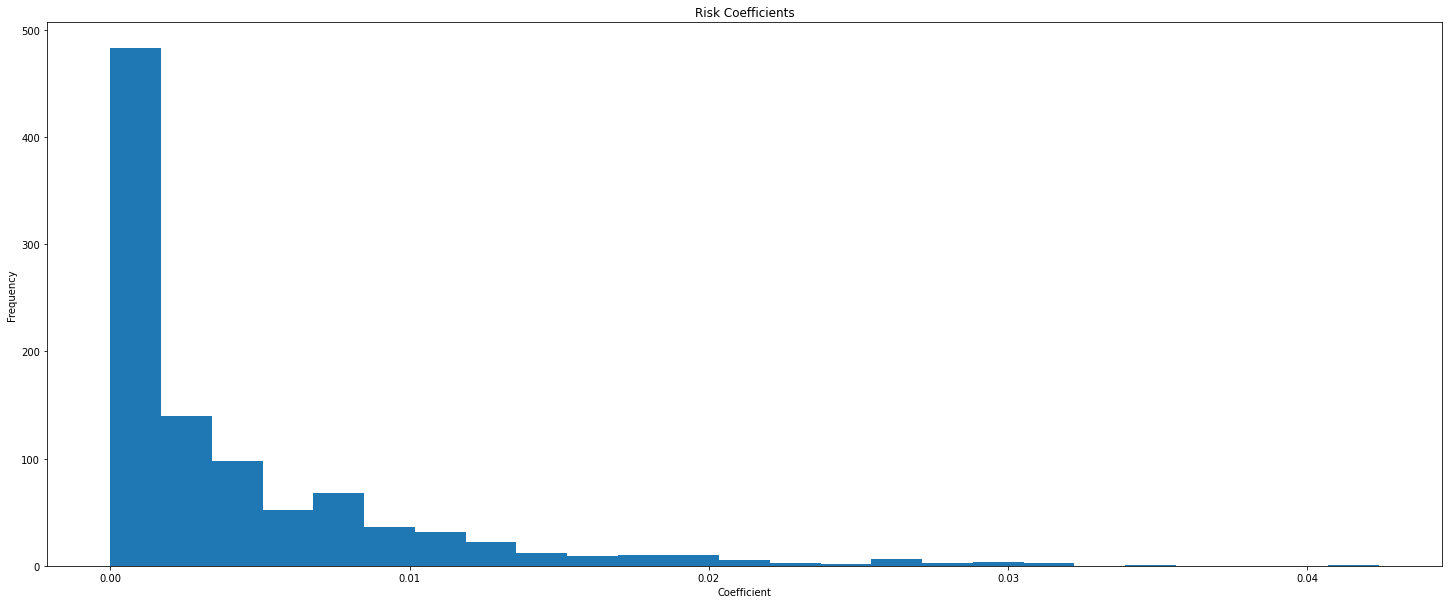

In [26]:
#Plots the distribution of risk coefficients.
plt.figure(figsize=(25,10))

plt.hist(beta_risk_coefficients, bins=25)
plt.title('Risk Coefficients')
plt.xlabel('Coefficient')
plt.ylabel('Frequency')

plt.show()

### Risk Coefficient Histogram
* Above, we have the distribution of the risk coefficients of the various itterations from the simulation. Notice, that there is distinct region with higher frequency. This is caused from the nature of stock weightings. From this graph, we can conclude that it is easier to acheive lower/average risk coefficients compared to those with higher risk coefficients at the right.

# We will also create a backdated plot comparing the portfolio with the lowest risk coefficient to the one with the highest risk coefficient.

In [27]:
low_coeff_beta_shares = beta_risk_coefficients[min(beta_risk_coefficients.keys())]
low_coeff_beta_df = pd.DataFrame()
low_coeff_beta_df.index = filtered_ticker_hist.index
for ticker in list(low_coeff_beta_shares.keys()):
    low_coeff_beta_df[ticker] = filtered_ticker_hist[ticker].Close * low_coeff_beta_shares[ticker]
low_coeff_beta_df['Portfolio Value'] = low_coeff_beta_df.sum(axis=1)

In [28]:
high_coeff_beta_shares = beta_risk_coefficients[max(beta_risk_coefficients.keys())]
high_coeff_beta_df = pd.DataFrame()
high_coeff_beta_df.index = filtered_ticker_hist.index
for ticker in list(high_coeff_beta_shares.keys()):
    high_coeff_beta_df[ticker] = filtered_ticker_hist[ticker].Close * high_coeff_beta_shares[ticker]
high_coeff_beta_df['Portfolio Value'] = high_coeff_beta_df.sum(axis=1)

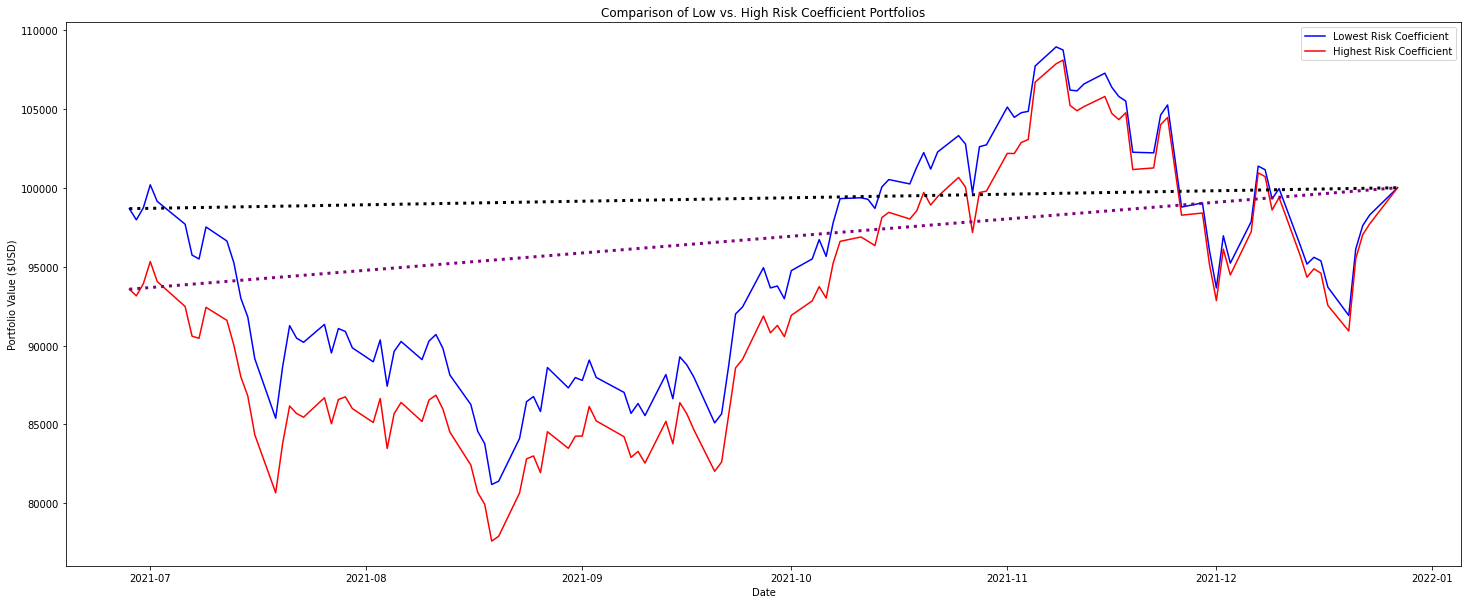

In [29]:
#Plots the distribution of risk coefficients.
plt.figure(figsize=(25,10))

plt.plot(low_coeff_beta_df.index, low_coeff_beta_df['Portfolio Value'], color='blue', label='Lowest Risk Coefficient')
plt.plot(high_coeff_beta_df.index, high_coeff_beta_df['Portfolio Value'], color='red', label='Highest Risk Coefficient')

# Plot line that connects first day's price to current price
plt.plot([high_coeff_beta_df.index[0], high_coeff_beta_df.index[-1]], [high_coeff_beta_df['Portfolio Value'].iloc[0], high_coeff_beta_df['Portfolio Value'].iloc[-1]], color='purple', linewidth=3, linestyle=':')
plt.plot([low_coeff_beta_df.index[0], low_coeff_beta_df.index[-1]], [low_coeff_beta_df['Portfolio Value'].iloc[0], low_coeff_beta_df['Portfolio Value'].iloc[-1]], color='black', linewidth=3, linestyle=':')

plt.legend(loc='best')
plt.title('Comparison of Low vs. High Risk Coefficient Portfolios')
plt.xlabel('Date')
plt.ylabel('Portfolio Value ($USD)')

plt.show()

### Comparison of Low vs. High Risk Coefficient Portfolios
* As you can see, we have back tested both portfolios and plotted the average return lines (connects first and last points). The portfolio with the higher risk coefficient has ***a much*** higher slope in relation to the portfolio with the lower risk coefficient. This then proves that the higher the risk coefficient, the greater the magnitude of change is. 
* Note, that the direction of change is apparent on both portfolios since they contain the same stocks. However, the weightings of stocks are drastically different, which results in the amplitude of change being different. 

*** 
# Options Analysis

In [30]:
if len(option_interest_dict.keys()) >= 10:
    # Number of iterations - Larger Numbers produce higher accuracy but take longer
    trials = TRIALS

    #Uses the Monte Carlo Method on the second potential final list (the one derived from options analysis)
    start_day = (datetime.now() - timedelta(days=60)).strftime("%Y-%m-%d")
    opt_end = (datetime.now() - pd.tseries.offsets.BDay(DELTA)).strftime("%Y-%m-%d")
    options_risk_coefficients = {}

    # We will be trading space efficiency for time efficiency
    def run_monte_carlo_opt(start, end, tickers):
        weight_list = get_weight_list()
        result = monte_carlo(weight_list, start, end, tickers)
        options_risk_coefficients[result[0]] = result[1]


    # Threaded Calls
    threads = []

    for i in range(trials):
        thread = Thread(target=run_monte_carlo_opt, args=(start_day, end_day, opt_tickers))
        threads.append(thread)
        thread.start()

    for thread in threads:
        thread.join()

    # deprecated code to run custom weights    
    def run_monte_carlo_custom_opt(start, end, weight_list, tickers=opt_tickers):
        result = monte_carlo(weight_list, start, end, tickers)
        options_risk_coefficients[result[0]] = result[1]

else:
    print('Error - Insufficient Options Data for tickers in Tickers.csv, skipping analysis...')

In [31]:
optimal_weight

{'GM': 143.98799800259656,
 'SU': 346.0154368112557,
 'AXP': 39.77408335505635,
 'BA': 56.792152593646094,
 'SPG': 91.03754080575513,
 'BB': 613.7479790805365,
 'CAE': 319.75150450268274,
 'OXY': 168.69096163835331,
 'CVE': 1078.6489547519845,
 'ERF': 1680.702020383795}

In [32]:
if len(option_interest_dict.keys()) >= 10:
    print(f'The maximum risk coefficient for our beta portfolio was {max(options_risk_coefficients.keys())}')

The maximum risk coefficient for our beta portfolio was 0.009451681515909237


### Below, is the histogram of the distribution of risk coefficients of the iterations of the options method

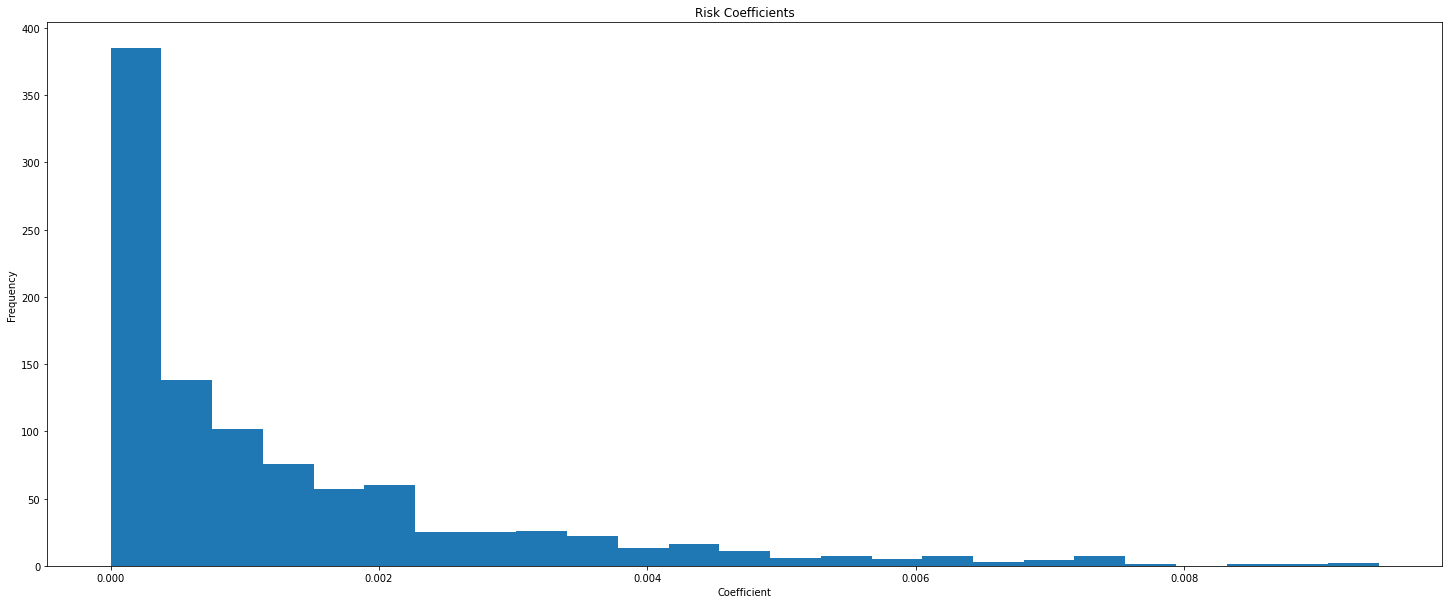

In [33]:
if len(option_interest_dict.keys()) >= 10:
    # Plots the risk coefficients of all the weights of the second final list candidate
    plt.figure(figsize=(25,10))

    plt.hist(options_risk_coefficients, bins=25)
    plt.title('Risk Coefficients')
    plt.xlabel('Coefficient')
    plt.ylabel('Frequency')

    plt.show()

* Note, we are not able to show a backtested plot for the range of portfolios from the options analysis as it relies on very recent data, so it is only effective in the forwards direction. These stocks may not have been correlated in the past, but we expect them to be correlated in the short term in the future, so for the sake of the competition, this method is quite effective.

***
# Final Portfolio Approach
* Now that we have completed the simulations for both methods, we can now compare our results to see which one provides us with a more desireable (higher) risk coefficient.

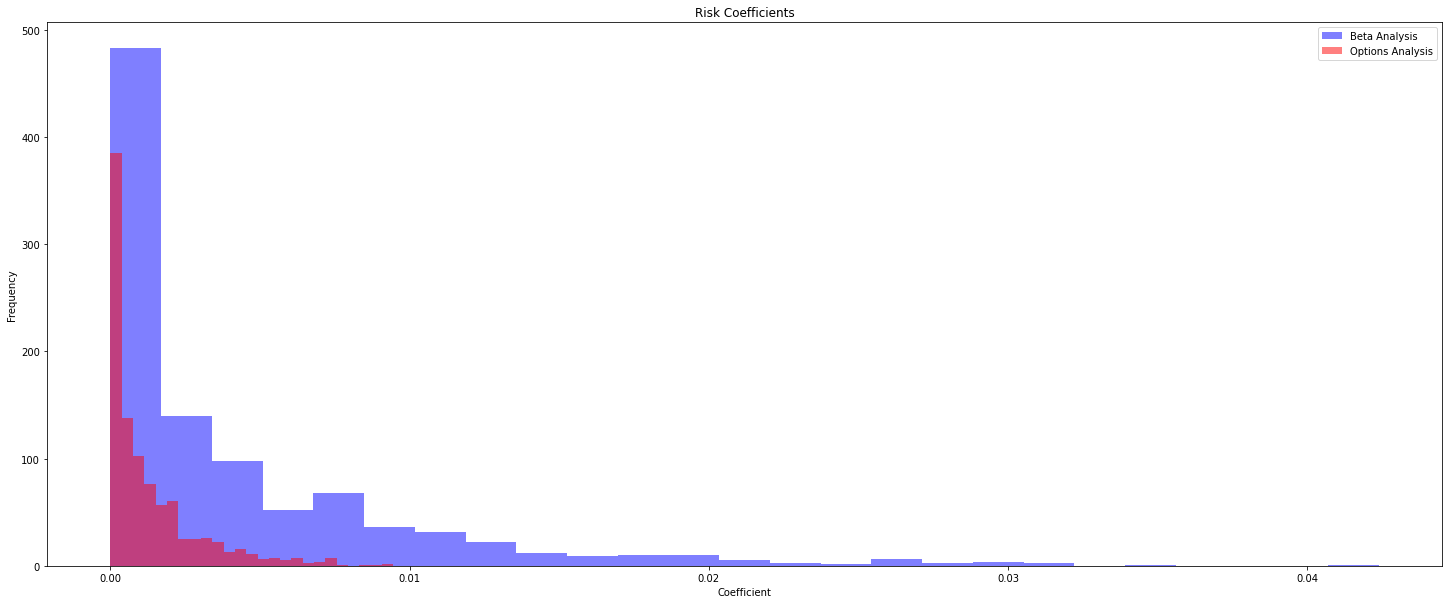

In [34]:
if len(option_interest_dict.keys()) >= 10:
    # Plots the risk coefficients of all the weights of the second final list candidate
    plt.figure(figsize=(25,10))


    plt.hist(beta_risk_coefficients, bins=25, color='blue', alpha=0.50, label='Beta Analysis')
    plt.hist(options_risk_coefficients, bins=25, color='red', alpha=0.5, label='Options Analysis')
    plt.legend(loc='best')
    plt.title('Risk Coefficients')
    plt.xlabel('Coefficient')
    plt.ylabel('Frequency')

    plt.show()

* We can see the comparison between both methods above. Our program will choose the portfolio with the highest risk coefficient, regardless of whichever method it came from.

***
## Comparing the two methods

* After we have calculated the "best" portfolios for each method, we will determine which one is best before outputting it as the final portfolio.

In [35]:
final_risk_coefficients_dict = beta_risk_coefficients.copy()

if len(option_interest_dict.keys()) >= 10:
    final_risk_coefficients_dict.update(options_risk_coefficients)

In [36]:
final_optimal_weight = final_risk_coefficients_dict[max(final_risk_coefficients_dict.keys())]

In [37]:
if len(option_interest_dict.keys()) < 10:
    print("The data used for the final portfolio came from the Beta Method")
    
elif final_optimal_weight in beta_risk_coefficients.values():
    print("The data used for the final portfolio came from the Beta Method")
    
else:
    print("The data used for the final portfolio came from the Options Method")
    

The data used for the final portfolio came from the Beta Method


In [38]:
# Moves final_optimal_weight into a dataframe.
final_stocks_df = pd.DataFrame.from_dict(final_optimal_weight, orient='index')
final_stocks_df.reset_index(inplace=True)
final_stocks_df.columns = ['Ticker', 'Shares']

In [39]:
final_stocks_df

,Ticker,Shares
0,GM,143.987998
1,SU,346.015437
2,AXP,39.774083
3,BA,56.792153
4,SPG,91.037541
5,BB,613.747979
6,CAE,319.751505
7,OXY,168.690962
8,CVE,1078.648955
9,ERF,1680.702020


## Create final output DataFrame
* Finally, we have our desired list of stocks, along with their respective weightings. We can now build our final portfolio.
* We will first format the DataFrame to meet the assignment specifications.

In [40]:
# Create a new DataFrame that matches the assignment requirements
FinalPortfolio = pd.DataFrame(final_stocks_df['Ticker'].copy())

# Create a series of closing prices for the tickers in our final portfolio
closing_prices = [filtered_ticker_hist[ticker].Close.loc[end_day] for ticker in FinalPortfolio['Ticker'].values]

# Add necessary columns to the final DataFrame, as required
FinalPortfolio['Price'] = pd.Series(closing_prices)
FinalPortfolio['Shares'] = final_stocks_df['Shares']
FinalPortfolio['Value'] = FinalPortfolio['Shares'] * FinalPortfolio['Price']

FinalPortfolio['Weight'] = FinalPortfolio['Value'] / FinalPortfolio['Value'].sum()
FinalPortfolio.index += 1

***
# Double Check that Stock Values add to $100,000

In [41]:
print(f"The portfolio's total value is ${FinalPortfolio['Value'].sum():.2f}")

The portfolio's total value is $100000.00


In [42]:
print(f"The total weight of all stocks in the portfolio is {FinalPortfolio['Weight'].sum()*100:.0f}%")

The total weight of all stocks in the portfolio is 100%


***
# Output Final DataFrame as CSV

In [43]:
FinalPortfolio[['Ticker', 'Shares']].to_csv('Portfolio.csv')

In [44]:
FinalPortfolio

,Ticker,Price,Shares,Value,Weight
1,GM,57.430000,143.987998,8269.230769,0.082692
2,SU,25.010000,346.015437,8653.846154,0.086538
3,AXP,164.389999,39.774083,6538.461538,0.065385
4,BA,203.169998,56.792153,11538.461538,0.115385
5,SPG,158.429993,91.037541,14423.076923,0.144231
6,BB,9.400000,613.747979,5769.230769,0.057692
7,CAE,25.260000,319.751505,8076.923077,0.080769
8,OXY,29.639999,168.690962,5000.000000,0.050000
9,CVE,12.480000,1078.648955,13461.538462,0.134615
10,ERF,10.870000,1680.702020,18269.230769,0.182692
